In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from keras.optimizers import Adam
from keras.metrics import Accuracy
from keras.models import load_model
from keras.utils import np_utils
from matplotlib import pyplot as plt
import os
import cv2
import imghdr
import numpy as np
import cv2
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

## GPU Allocation

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Kaggle Data

In [ ]:
os.environ['KAGGLE_USERNAME'] = '---' # kaggle API username
os.environ['KAGGLE_KEY'] = '---' # kaggle API key
! kaggle datasets download -d mostafaabla/garbage-classification

 99% 237M/239M [00:07<00:00, 43.0MB/s]
100% 239M/239M [00:07<00:00, 35.1MB/s]


In [ ]:
file_name = "/content/garbage-classification.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [ ]:
import shutil
dir = "/content/garbage_classification/"
trash_list = ['trash', 'clothes', 'battery', 'shoes']
recyc_list = ['plastic', 'brown-glass', 'white-glass', 'cardboard', 'green-glass', 'metal', 'paper']
comp_list = ['biological']
for folder in os.listdir(dir):
  if folder in trash_list:
    dir_path = dir + 'trash/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in recyc_list:
    dir_path = dir + 'recyc/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in comp_list:
    dir_path = dir + 'comp/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)

for folder in os.listdir(dir):
  if folder not in ['trash', 'recyc', 'comp']:
    os.rmdir(dir + folder)

In [ ]:
num_class = len(list(os.listdir(dir)))
print(f'There are {num_class} classes to classify')

There are 3 classes to classify


## Loading Data

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/garbage_classification')
data = data.map(lambda x,y: (int(x), y))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 15515 files belonging to 3 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


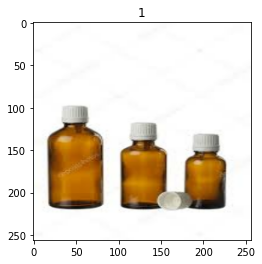

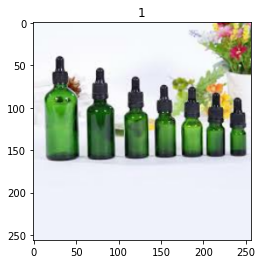

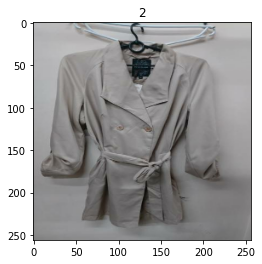

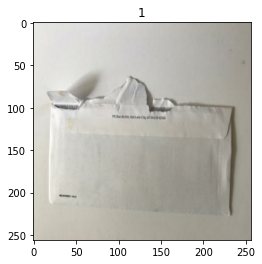

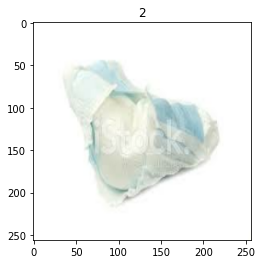

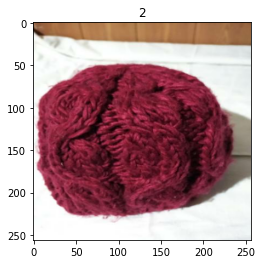

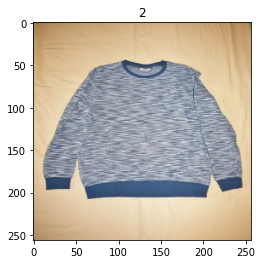

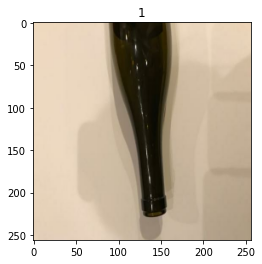

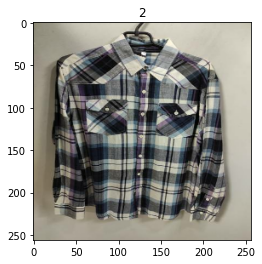

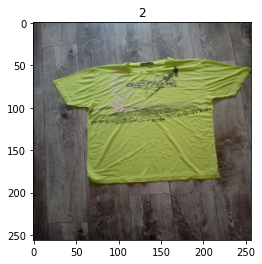

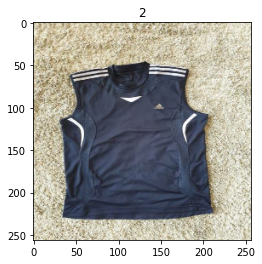

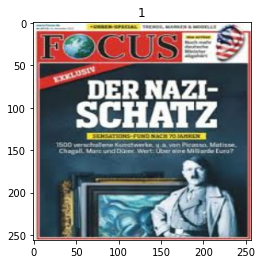

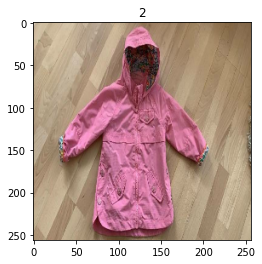

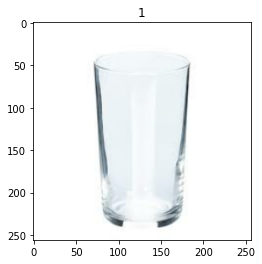

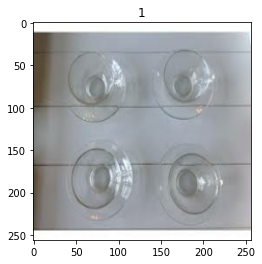

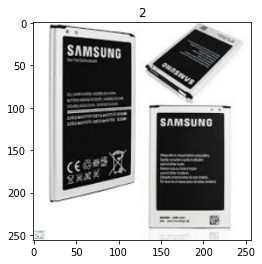

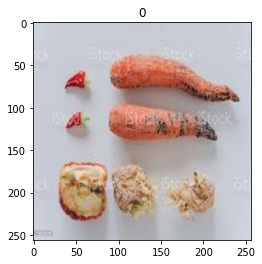

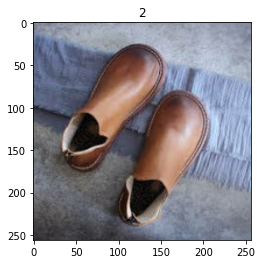

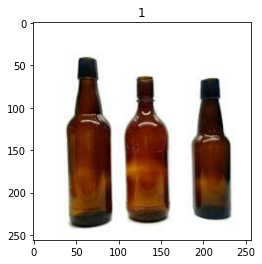

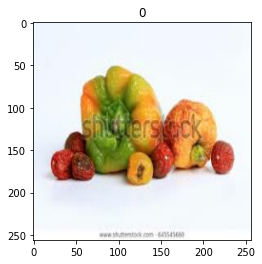

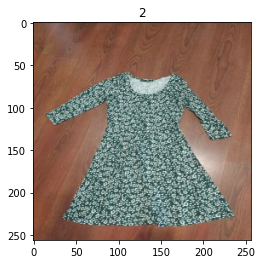

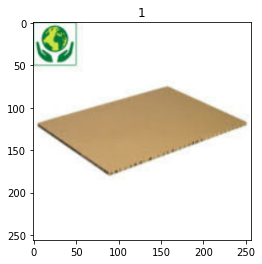

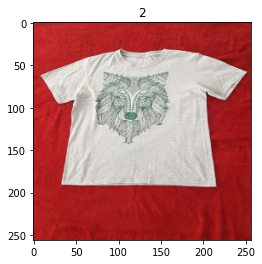

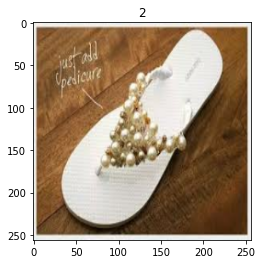

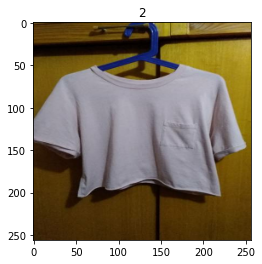

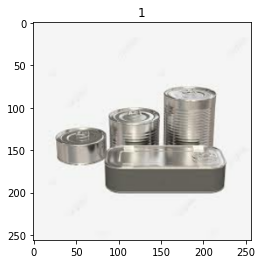

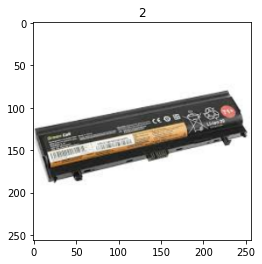

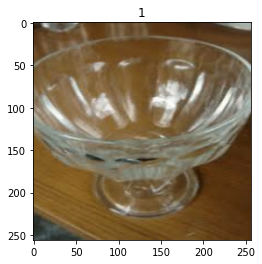

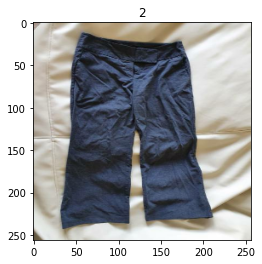

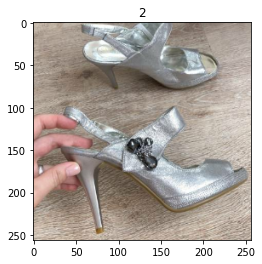

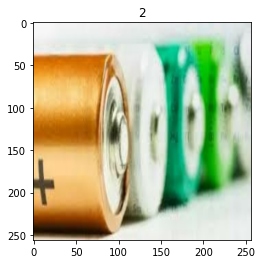

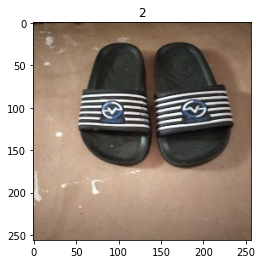

In [ ]:
for i, image in enumerate(batch[0]):
  plt.imshow(image)
  plt.title(batch[1][i])
  plt.show()

In [ ]:
data = data.map(lambda x,y: (x/255, y))

## Data Split

In [ ]:
train_size = int(round(len(data)*.6,0))
val_size = int(round(len(data)*.2,0))
test_size = int(round(len(data)*.2,0))

In [ ]:
val = data.take(val_size)
train = data.skip(val_size).take(train_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
y_train = np.concatenate([y for x, y in train], axis=0)
y_val = np.concatenate([y for x, y in val], axis=0)
y_test = np.concatenate([y for x, y in test], axis=0)

## CNN Model

In [ ]:
np.random.seed(1337) 
inputs = Input(shape=(256, 256, 3))

m = Conv2D(16, (3, 3), activation='relu')(inputs) 
m = MaxPooling2D(2, 2)(m)
m = Conv2D(32, (3, 3), activation='relu')(m)
m = MaxPooling2D(2, 2)(m)
m = Conv2D(64, (3, 3), activation='relu')(m)
m = Conv2D(64, (3, 3), activation='relu')(m)
m = MaxPooling2D(2, 2)(m)
m = Conv2D(128, (3, 3), activation='relu')(m)
m = Conv2D(128, (3, 3), activation='relu')(m)
m = MaxPooling2D(2, 2)(m)
m = Conv2D(256, (3, 3), activation='relu')(m)
m = Conv2D(256, (3, 3), activation='relu')(m)
m = Conv2D(256, (3, 3), activation='relu')(m)
m = MaxPooling2D(2, 2)(m)
m = Flatten()(m)
m = Dense(512, activation='relu')(m)
m = Dense(512, activation='relu')(m)
fm = Dense(num_class, activation='softmax')(m)

sub_model = Model(inputs=inputs, outputs=m)
cnn_model = Model(inputs=inputs, outputs=fm)

In [ ]:
adam = Adam(lr=1e-4)

cnn_model.compile(optimizer=adam,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

hist = cnn_model.fit(train, epochs=20, validation_data = val)
loss, accuracy = cnn_model.evaluate(test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Epoch 1/20
291/291 [==============================] - 56s 136ms/step - loss: 0.7429 - accuracy: 0.6342 - val_loss: 0.6246 - val_accuracy: 0.7149
Epoch 2/20
291/291 [==============================] - 49s 140ms/step - loss: 0.6164 - accuracy: 0.7185 - val_loss: 0.5781 - val_accuracy: 0.7365
Epoch 3/20
291/291 [==============================] - 46s 132ms/step - loss: 0.5639 - accuracy: 0.7497 - val_loss: 0.5482 - val_accuracy: 0.7497
Epoch 4/20
291/291 [==============================] - 46s 132ms/step - loss: 0.5251 - accuracy: 0.7652 - val_loss: 0.5531 - val_accuracy: 0.7474
Epoch 5/20
291/291 [==============================] - 50s 146ms/step - loss: 0.4882 - accuracy: 0.7895 - val_loss: 0.4925 - val_accuracy: 0.7883
Epoch 6/20
291/291 [==============================] - 43s 127ms/step - loss: 0.4601 - accuracy: 0.7961 - val_loss: 0.4672 - val_accuracy: 0.7993
Epoch 7/20
291/291 [==============================] - 60s 178ms/step - loss: 0.4349 - accuracy: 0.8114 - val_loss: 0.4193 - val_ac

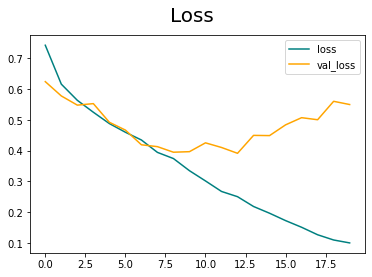

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

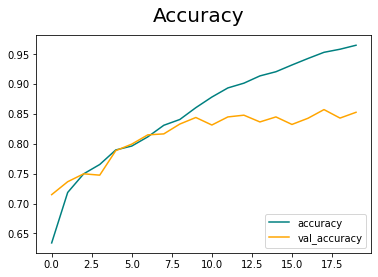

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [ ]:
sub_model.save('/content/CNN_FinalDenseLayer.h5')
cnn_model.save('/content/CNN_3Class_Best.h5')

In [ ]:
from google.colab import files
files.download('CNN_3Class_Best.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Taking Final Dense Layer to Use in Different Models

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_xg = sub_model.predict(train)
val_xg = sub_model.predict(val)
test_xg = sub_model.predict(test)

97/97 [==============================] - 32s 69ms/step


In [ ]:
train_xg.shape, val_xg.shape, test_xg.shape

((9312, 512), (3104, 512), (3099, 512))

In [ ]:
z = np.concatenate([np.array(train_xg).reshape(train_xg.shape[0],train_xg.shape[1]),np.array(y_train).reshape(train_xg.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('train_xg.csv',index=False)

z = np.concatenate([np.array(val_xg).reshape(val_xg.shape[0],val_xg.shape[1]),np.array(y_val).reshape(val_xg.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('val_xg.csv',index=False)

z = np.concatenate([np.array(test_xg).reshape(test_xg.shape[0],test_xg.shape[1]),np.array(y_test).reshape(test_xg.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('test_xg.csv',index=False)

In [ ]:
files.download('train_xg.csv')
files.download('val_xg.csv')
files.download('test_xg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## CNN Predicts

Saving cardboard.jpg to cardboard.jpg


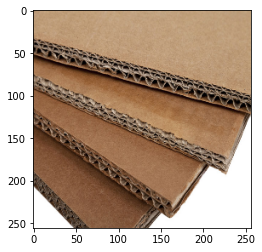

1/1 [==============================] - 0s 23ms/step


'recyc'

In [ ]:
predict_dict = {0: 'comp',
                1: 'recyc',
                2: 'trash'}

uploaded = files.upload()
f_name = [str(key) for key in uploaded.keys()][0]

img = cv2.imread(f'/content/{f_name}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = cnn_model.predict(np.expand_dims(resize/255, 0))

predict_dict[int(np.argmax(yhat, axis = 1))]